# Project 1
*Lasse Uttian, Alexander Laloi Dybdahl*

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.sparse import diags, bmat
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve_banded


In [325]:

def plot_solution(X, Y, U, g, title=None):
    fig = plt.figure(figsize=plt.figaspect(0.3))
    fig.tight_layout(pad=2.0)
    if title:
        fig.suptitle(title, fontsize=15)
    angle=80

    ax1 = fig.add_subplot(1, 3, 1, projection="3d")
    ax1.plot_surface(X, Y, U, cmap=cm.coolwarm)
    ax1.view_init(azim=angle)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('T')
    ax1.set_title('Solution for ∆T = -f')

    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    surf = ax2.plot_surface(X, Y, g(X, Y), cmap=cm.coolwarm)
    ax2.view_init(azim=angle)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('T')
    ax2.set_title('Exact solution for ∆T = -f')

    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    surf = ax3.plot_surface(X, Y, U - g(X, Y), cmap=cm.coolwarm)
    ax3.view_init(azim=angle)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('T')
    ax3.set_title('Error')
    plt.show()

In [326]:
def plot_convergence(X, Y, poisson, f, g, M=8, num=4, title=None):
    Econv = np.zeros(num)
    Hconv = np.zeros(num)
    for i in range(num):
        X, Y, U = poisson(f, g, M=M)
        Econv[i] = np.max(np.nan_to_num(np.abs(U - g(X, Y))))
        Hconv[i] = X[0, 1] - X[0, 0]
        M *= 2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]

    plt.figure(figsize=(6,3))
    plt.loglog(Hconv, Econv, ".", label=f"p = {order:.2f}")
    plt.xlabel("h")
    plt.ylabel("error")
    plt.legend()
    if title:
        plt.title(title)
    plt.show()

def compare_convergence(X, Y, poisson1, poisson2, f, g, M=8, num=4, title=None):
    Econv1 = np.zeros(num)
    Hconv1 = np.zeros(num)

    Econv2 = np.zeros(num)
    Hconv2 = np.zeros(num)
    for i in range(num):
        X, Y, U1 = poisson1(f, g, M=M)
        Econv1[i] = np.max(np.nan_to_num(np.abs(U1 - g(X, Y))))
        Hconv1[i] = X[0, 1] - X[0, 0]
        
        X, Y, U2 = poisson2(f, g, M=M)
        Econv2[i] = np.max(np.nan_to_num(np.abs(U2 - g(X, Y))))
        Hconv2[i] = X[0, 1] - X[0, 0]
        M *= 2

    order1 = np.polyfit(np.log(Hconv1),np.log(Econv1),1)[0]
    order2 = np.polyfit(np.log(Hconv2),np.log(Econv2),1)[0]

    plt.figure(figsize=(6,3))
    plt.loglog(Hconv1, Econv1, label=f"p = {order1:.2f} - fattened boundary")
    plt.loglog(Hconv2, Econv2, label=f"p = {order2:.2f} - modified boundary")
    plt.xlabel("h")
    plt.ylabel("error")
    plt.legend()
    if title:
        plt.title(title)
    plt.show()


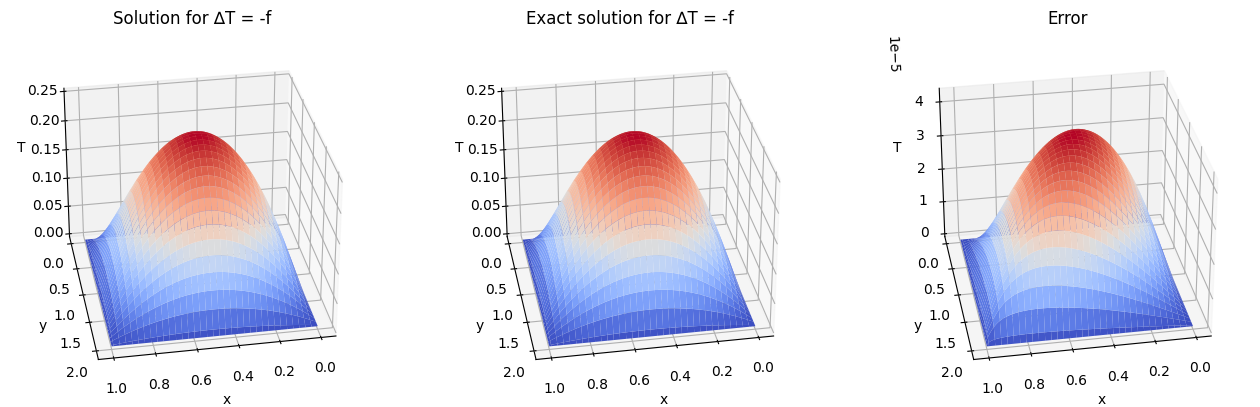

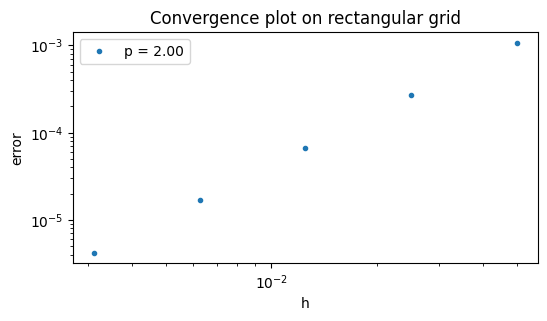

In [327]:
def get_bnd(M, N):
    bnd = np.ones((M, N))
    bnd[1:-1,1:-1] = np.zeros((M-2, N-2))
    return bnd

def poisson(f, g, a=1, r=2, M = 100, x_end=1, y_end=2):

    x = np.linspace(0, x_end, M+1, endpoint=True)
    y = np.linspace(0, y_end, M+1, endpoint=True)

    X, Y = np.meshgrid(x, y)

    bnd = get_bnd(M+1, M+1)

    h = x[1] - x[0]
    k = y[1] - y[0]

    U = g(X, Y)*bnd 

    F = f(X, Y)[1:-1,1:-1]
    F = F.ravel()

    Q = (
        np.roll(np.roll(U, 1, 0), 1, 1) +
        np.roll(np.roll(U, -1, 0), -1, 1) +
        a*np.roll(U, 1, 1) +
        a*np.roll(U, -1, 1)   
    ) 
    q = (Q[1:-1, 1:-1]*get_bnd(M-1, M-1)).ravel() / h**2

    C = 2*(a+1)*np.ones((M-1)**2)

    V = -a*np.ones((M-1)**2 - 1)
    V[M-2::M-1] = 0

    H = -np.ones((M-1)**2 - M)
    H[M-2::M-1] = 0

    A = diags([H, V, C, V, H], [-M, -1, 0, 1, M], ((M-1)**2, (M-1)**2), "csc") / h**2

    U[1:-1, 1:-1] = spsolve(A,q + F).reshape(M-1, M-1)

    return X, Y, U


def g1(x, y):
    return x*y*(x-1)*(y-2)

def f1(x, y, a=1, r=2):
    return -(2*(a+1)*y**2 + 2*r**2*x**2 + 8*r*x*y -4*(a + 1 + r)*y - (8*r + 2*r**2)*x + 4*r)

M = 100

X, Y, U = poisson(f1, g1, M=M)

plot_solution(X, Y, U, g1)
plot_convergence(X, Y, poisson, f1, g1, M=20, num=5, title='Convergence plot on rectangular grid')



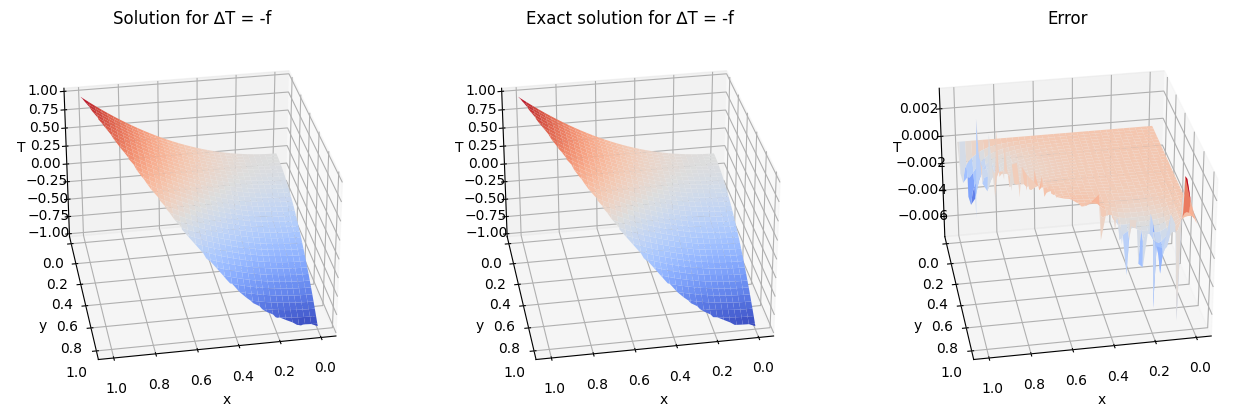

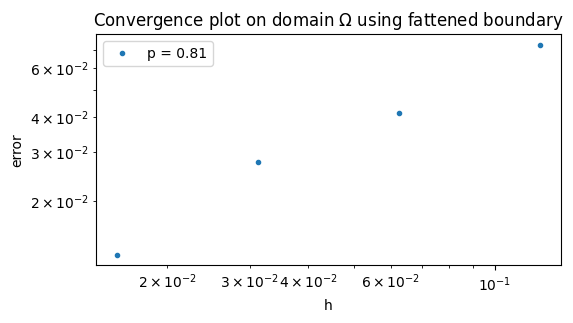

In [328]:
def normal_extension(x, y):
    roots = np.roots([-2, 0, 1-2*y, x])
    r = np.real(roots[np.argmin(np.imag(roots)**2)])
    return r, 1-r**2

def poisson_fattened(f, g, M = 100):
    
    x = np.linspace(0, 1, M+1, endpoint=True)
    y = np.linspace(0, 1, M+1, endpoint=True)
    X, Y = np.meshgrid(x, y)

    h = x[1] - x[0]
    d = h/2

    A = np.zeros(((M+1)**2, (M+1)**2))
    b = np.zeros((M+1)**2)

    for i in range(M+1):
        for j in range(M+1):
            k = i*(M+1) + j
            x = i*h
            y = j*h
            if i == 0 or j == 0: # dirichlet on the boundary
                A[k,k] = 1
                b[k] = g(x, y)
            elif y >= 1 - x**2 - d: # fattened boundary
                A[k, k] = 1
                xq, yq = normal_extension(x, y) # ghost point
                b[k] = g(xq, yq)
            else: # points inside the domain
                A[k,k] = -4/h**2
                A[k,k-1] = 1/h**2
                A[k,k+1] = 1/h**2
                A[k,k-(M+1)] = 1/h**2
                A[k,k+(M+1)] = 1/h**2
                b[k] = f(x, y)

    U = np.linalg.solve(A, b).reshape((M+1, M+1)).T

    interior = np.zeros_like(X)
    interior[Y <= 1 - X**2] = 1
    U[interior == 0] = X[interior == 0] = Y[interior == 0] = None
    
    return X, Y, U

M = 100
f = lambda x, y: -2*np.sin(x)*np.sin(y)
g = lambda x, y: np.sin(x)*np.sin(y)

X, Y, U = poisson_fattened(f, g, M = 100)

plot_solution(X, Y, U, g)
plot_convergence(X, Y, poisson_fattened, f, g, M=8, num=4, title=r'Convergence plot on domain $\Omega$ using fattened boundary')

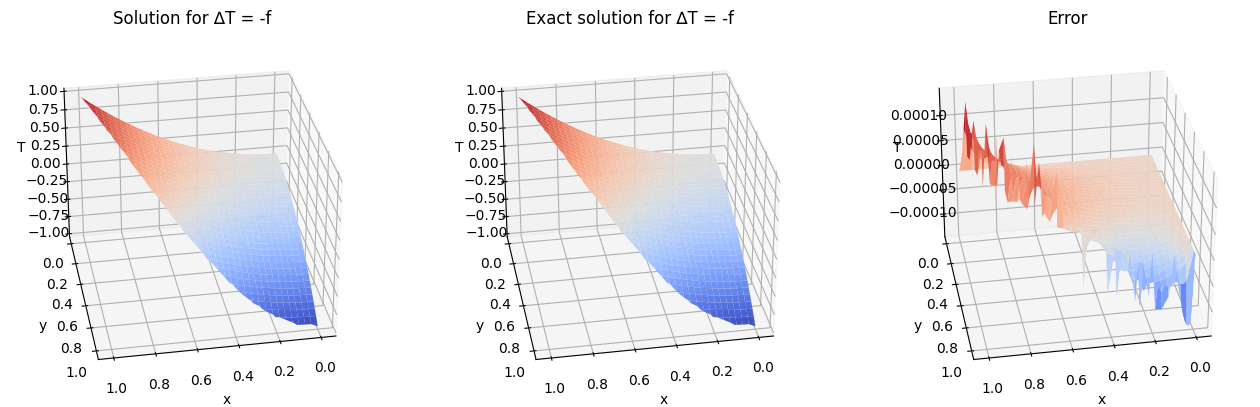

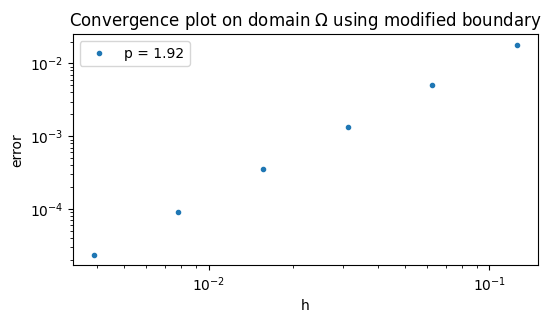

In [329]:
def gamma(x):
    return 1 - x**2

def gamma_inv(y):
    return np.sqrt(1 - y)

def poisson_modified(f, g, M = 100):
    x = np.linspace(0, 1, M+1, endpoint=True)
    y = np.linspace(0, 1, M+1, endpoint=True)

    h = x[1] - x[0]

    X, Y = np.meshgrid(x, y)

    interior = np.zeros_like(X)

    boundary_hit = np.zeros_like(X)
    boundary_hit[X == 0] = 1
    boundary_hit[Y == 0] = 1
    boundary_hit[Y == gamma(X)] = 1
    boundary_hit[X == gamma_inv(Y)] = 1

    interior = np.zeros_like(X)
    interior[Y < gamma(X)] = 1
    interior[boundary_hit == 1] = 0

    exterior = np.zeros_like(X)
    exterior[Y > gamma(X)] = 1
    exterior[boundary_hit == 1] = 0

    dist_y = (np.roll(gamma(X), 1, 0) - Y) / h
    dist_y[interior + np.roll(exterior, -1, 0) != 2] = 0

    dist_x = (np.roll(gamma_inv(Y), 1, 1) - X) / h
    dist_x[interior + np.roll(exterior, -1, 1) != 2] = 0

    north_boundary = np.zeros_like(X)
    north_boundary[dist_y != 0] = 1
    
    east_boundary = np.zeros_like(X)
    east_boundary[dist_x != 0] = 1

    interior_no_bnd = interior.copy()
    interior_no_bnd[north_boundary == 1] = 0
    interior_no_bnd[east_boundary == 1] = 0


    Q = (
        g(X, Y) * boundary_hit +
        g(X, gamma(X)) * np.divide(2, dist_y*(1+dist_y), out=np.zeros_like(X), where=dist_y != 0) / h**2 +
        g(gamma_inv(Y), Y) * np.divide(2, dist_x*(1+dist_x), out=np.zeros_like(X), where=dist_x != 0) / h**2
    ).ravel()

    F = (f(X, Y) * interior).ravel()

    P = boundary_hit + exterior + (4*interior_no_bnd + north_boundary*np.divide(2, dist_y, out=np.zeros_like(X), where=dist_y != 0) + east_boundary*np.divide(2, dist_x, out=np.zeros_like(X), where=dist_x != 0)) / h**2

    N = -interior_no_bnd / h**2
    S = (-interior_no_bnd - north_boundary*np.divide(2, 1+dist_y, out=np.zeros_like(X), where=dist_y != 0)) / h**2
    E = -interior_no_bnd / h**2
    W = (-interior_no_bnd - east_boundary*np.divide(2, 1+dist_x, out=np.zeros_like(X), where=dist_x != 0) )/ h**2

    A = diags([S.ravel()[M+1:], W.ravel()[1:], P.ravel(), E.ravel()[:-1], N.ravel()[:-(M+1)]], [-(M+1), -1, 0, 1, M+1], ((M+1)**2, (M+1)**2), "csc")


    U = spsolve(A, Q - F).reshape(M+1, M+1)

    U[exterior == 1] = None

    X[exterior == 1] = None
    Y[exterior == 1] = None

    return X, Y, U

M = 100

X, Y, U = poisson_modified(f, g, M = M)

plot_solution(X, Y, U, g)
plot_convergence(X, Y, poisson_modified, f, g, M=8, num=6, title=r'Convergence plot on domain $\Omega$ using modified boundary')


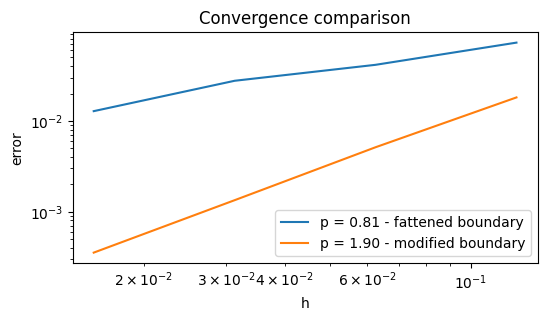

In [330]:
compare_convergence(X, Y, poisson_fattened, poisson_modified, f, g, M=8, num=4, title='Convergence comparison')